# Mini Lab 1
## Logistic Regression and SVMs

Sydney Holder, Leonardo Leal, Alonso Salcido

In [177]:
# Loading the train.csv dataset.
df = pd.read_csv(r'financial_data.csv', low_memory=False)
# Checking the first 5 rows of the dataframe.
df.head()

Unnamed: 0      ID Customer_ID     Month           Name   Age          SSN  \
0           0  0x1602   CUS_0xd40   January  Aaron Maashoh  23.0  821-00-0265   
1           1  0x1603   CUS_0xd40  February  Aaron Maashoh  23.0  821-00-0265   
2           2  0x1604   CUS_0xd40     March  Aaron Maashoh  23.0  821-00-0265   
3           3  0x1605   CUS_0xd40     April  Aaron Maashoh  23.0  821-00-0265   
4           4  0x1606   CUS_0xd40       May  Aaron Maashoh  23.0  821-00-0265   

  Occupation  Annual_Income  Monthly_Inhand_Salary  ...  Auto_Loan  \
0  Scientist       19114.12            1824.843333  ...        1.0   
1  Scientist       19114.12            1824.843333  ...        1.0   
2  Scientist       19114.12            1824.843333  ...        1.0   
3  Scientist       19114.12            1824.843333  ...        1.0   
4  Scientist       19114.12            1824.843333  ...        1.0   

   Credit_Builder_Loan  Not_Specified_Loan  Personal_Loan Payday_Loan  \
0                  1.0                 0.0            1.0         0.0   
1                  1.0                 0.0            1.0         0.0   
2                  1.0                 0.0            1.0         0.0   
3                  1.0                 0.0            1.0         0.0   
4                  1.0                 0.0            1.0         0.0   

   Mortgage_Loan  Home_Equity_Loan  Debt_Consolidation_Loan  Student_Loan  \
0            0.0               1.0                      0.0           0.0   
1            0.0               1.0                      0.0           0.0   
2            0.0               1.0                      0.0           0.0   
3            0.0               1.0                      0.0           0.0   
4            0.0               1.0                      0.0           0.0   

  Late_Payer  
0          0  
1          0  
2          0  
3          0  
4          0  

[5 rows x 40 columns]

In [178]:
## Create Dummies for Payment Behaviour
Payment_Dummies= pd.get_dummies(df.Payment_Behaviour)
df = df.join(Payment_Dummies)

In [179]:
## Create Dummies for Occupation
Occupation_Dummies= pd.get_dummies(df.Occupation)
df = df.join(Occupation_Dummies)

In [180]:
## Turn Payment_of_Min_Amount into Numeric
df.Payment_of_Min_Amount = df.Payment_of_Min_Amount.str.replace('Yes','1')
df.Payment_of_Min_Amount = df.Payment_of_Min_Amount.str.replace('No','0')
df.Payment_of_Min_Amount = pd.to_numeric(df.Payment_of_Min_Amount, errors='coerce')
df.Payment_of_Min_Amount.describe()

count    100000.000000
mean          0.594320
std           0.491026
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: Payment_of_Min_Amount, dtype: float64

In [181]:
## Turn Credit_Mix into Numeric
df.Credit_Mix = df.Credit_Mix.str.replace('Bad','0')
df.Credit_Mix = df.Credit_Mix.str.replace('Standard','1')
df.Credit_Mix = df.Credit_Mix.str.replace('Good','2')
df.Credit_Mix = pd.to_numeric(df.Credit_Mix, errors='coerce')
df.Credit_Mix.describe()

count    100000.000000
mean          1.066160
std           0.732904
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           2.000000
Name: Credit_Mix, dtype: float64

In [182]:
## Turn Credit_Score into Numeric
df.Credit_Score = df.Credit_Score.str.replace('Poor','0')
df.Credit_Score = df.Credit_Score.str.replace('Standard','1')
df.Credit_Score = df.Credit_Score.str.replace('Good','2')
df.Credit_Score = pd.to_numeric(df.Credit_Score, errors='coerce')
df.Credit_Score.describe()

count    100000.00000
mean          0.88830
std           0.67512
min           0.00000
25%           0.00000
50%           1.00000
75%           1.00000
max           2.00000
Name: Credit_Score, dtype: float64

In [183]:
## Drop Non Numeric Fields
df_imputed= df.drop(columns=['ID', 'Customer_ID', 'Month', 'Name', 'SSN', 'Type_of_Loan', 'Payment_Behaviour', 'Occupation'])

In [184]:
## Rearrange Dataframe
Credit_Score = df_imputed['Credit_Score']
df_imputed = df_imputed.drop(columns=['Credit_Score'])
df_imputed.insert(loc=0, column='Credit_Score', value=Credit_Score)

# 1. Create Models
## SVM and Logistic Regression Modeling 

### Training and Testing Split

In [185]:
from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if 'Credit_Score' in df_imputed:
    y = df_imputed['Credit_Score'].values # get the labels we want
    del df_imputed['Credit_Score'] # get rid of the class label
    X = df_imputed.values # use everything else to predict!
    
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2, random_state=0)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=0, test_size=0.2, train_size=None)


# Logistic Regression

In [186]:
# run logistic regression and vary some parameters
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None, solver='liblinear' ) # get object

# now we can use the cv_object that we setup before to iterate through the 
#    different training and testing sets. Each time we will reuse the logisitic regression 
#    object, but it gets trained on different data each time we use it.

iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # train the reusable logisitc regression model on the training data
    lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test) # get test set precitions

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    iter_num+=1
    
# Also note that every time you run the above code
#   it randomly creates a new training and testing set, 
#   so accuracy will be different each time

====Iteration 0  ====
accuracy 0.6259
confusion matrix
 [[2983 2607  236]
 [1446 8328  811]
 [  47 2335 1207]]
====Iteration 1  ====
accuracy 0.62555
confusion matrix
 [[2984 2556  261]
 [1516 8170  939]
 [  61 2156 1357]]
====Iteration 2  ====
accuracy 0.6349
confusion matrix
 [[3018 2470  312]
 [1448 8096 1030]
 [  87 1955 1584]]


In [187]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.66      0.52      0.58      5800
           1       0.65      0.77      0.70     10574
           2       0.54      0.44      0.48      3626

    accuracy                           0.63     20000
   macro avg       0.62      0.57      0.59     20000
weighted avg       0.63      0.63      0.63     20000



In [188]:
from sklearn.preprocessing import StandardScaler

# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)
# to Make things easier, let's start by just using whatever was last stored in the variables:
##    X_train , y_train , X_test, y_test (they were set in a for loop above)

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

# train the model just as before
lr_clf = LogisticRegression(penalty='l2', C=0.05, solver='liblinear') # get object, the 'C' value is less (can you guess why??)
lr_clf.fit(X_train_scaled,y_train)  # train object

y_hat = lr_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf )

accuracy: 0.6555
[[3041 2313  446]
 [1387 7963 1224]
 [  67 1453 2106]]


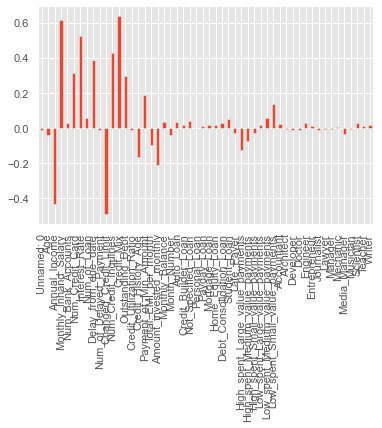

In [189]:
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


weights = pd.Series(lr_clf.coef_[0],index=df_imputed.columns)
weights.plot(kind='bar')
plt.show()

In [190]:
from sklearn.preprocessing import StandardScaler
# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)

from sklearn.pipeline import Pipeline
# you can apply the StandardScaler function inside of the cross-validation loop 
#  but this requires the use of PipeLines in scikit. 
#  A pipeline can apply feature pre-processing and data fitting in one compact notation
#  Here is an example!

std_scl = StandardScaler()
lr_clf = LogisticRegression(penalty='l2', C=0.05, solver='liblinear') 

# create the pipline
piped_object = Pipeline([('scale', std_scl),  # do this
                         ('logit_model', lr_clf)]) # and then do this

weights = []
# run the pipline cross validated
for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    piped_object.fit(X[train_indices],y[train_indices])  # train object
    # it is a little odd getting trained objects from a  pipeline:
    weights.append(piped_object.named_steps['logit_model'].coef_[0])
    

weights = np.array(weights)

In [191]:
import plotly
plotly.offline.init_notebook_mode() # run at the start of every notebook

error_y=dict(
            type='data',
            array=np.std(weights,axis=0),
            visible=True
        )

graph1 = {'x': df_imputed.columns,
          'y': np.mean(weights,axis=0),
    'error_y':error_y,
       'type': 'bar'}

fig = dict()
fig['data'] = [graph1]
fig['layout'] = {'title': 'Logistic Regression Weights, with error bars'}

plotly.offline.iplot(fig)

In [194]:
Xnew = df_imputed[['Annual_Income','Num_Credit_Card','Interest_Rate', 'Delay_from_due_date', 'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt', 'Credit_History_Age', 'Payment_of_Min_Amount', 'Amount_invested_monthly', 'High_spent_Large_value_payments', 'Low_spent_Small_value_payments']].values

weights = []
# run the pipline corssvalidated
for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(Xnew,y)):
    piped_object.fit(Xnew[train_indices],y[train_indices])  # train object
    weights.append(piped_object.named_steps['logit_model'].coef_[0])
    
weights = np.array(weights)

error_y=dict(
            type='data',
            array=np.std(weights,axis=0),
            visible=True
        )

graph1 = {'x': ['Annual_Income','Num_Credit_Card','Interest_Rate', 'Delay_from_due_date', 'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt', 'Credit_History_Age', 'Payment_of_Min_Amount', 'Amount_invested_monthly', 'High_spent_Large_value_payments', 'Low_spent_Small_value_payments'],
          'y': np.mean(weights,axis=0),
    'error_y':error_y,
       'type': 'bar'}

fig = dict()
fig['data'] = [graph1]
fig['layout'] = {'title': 'Most Relevant Logistic Regression Weights, with error bars'}

plotly.offline.iplot(fig)

# 3. Interpretation of Logistic Regresion weights
We use the logistic regression model to predict credit score based on some customer behavior.
To obtain a better understanding of how some of the variables are affecting credit score we interpreted their weights:
- An increase in the monthly inhand salary increases the odds of having a higher credit score by a factor of 1.92, when all other features remain the same.
-  An increase in the credit history age increases the odds of a poorer credit score by a factor of 0.84, when all other features remain the same.
- An increase in total EMI (equated monthly installments) decreases the odds of a higher credit score by a factor of 0.887, when all other features remain the same. 

# Support Vector Machines

In [193]:
# okay, so run through the cross validation loop and set the training and testing variable for one single iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) 

In [173]:
# lets investigate SVMs on the data and play with the parameters and kernels
from sklearn.svm import SVC

# train the model just as before
svm_clf = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)

accuracy: 0.7279
[[3878 1428  494]
 [1187 8005 1382]
 [  34  917 2675]]


In [215]:
# lets investigate SVMs on the data and play with the parameters and kernels
from sklearn.svm import SVC

# train the model just as before
svm_clf = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto', decision_function_shape='ovo') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)

accuracy: 0.5287
[[    0  5800     0]
 [    0 10574     0]
 [    0  3626     0]]


In [174]:
# Now let's do some different analysis with the SVM and look at the instances that were chosen as support vectors

# now lets look at the support for the vectors and see if we they are indicative of anything
# grabe the rows that were selected as support vectors (these are usually instances that are hard to classify)

# make a dataframe of the training data
df_tested_on = df_imputed.iloc[train_indices].copy() # saved from above, the indices chosen for training
# now get the support vectors from the trained model
df_support = df_tested_on.iloc[svm_clf.support_,:].copy()

df_support['Credit_Score'] = y[svm_clf.support_] # add back in the 'Credit_Score' Column to the pandas dataframe
df_imputed['Credit_Score'] = y # also add it back in for the original data
df_support.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53230 entries, 32569 to 10928
Data columns (total 53 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0                        53230 non-null  int64  
 1   Age                               53230 non-null  float64
 2   Annual_Income                     53230 non-null  float64
 3   Monthly_Inhand_Salary             53230 non-null  float64
 4   Num_Bank_Accounts                 53230 non-null  float64
 5   Num_Credit_Card                   53230 non-null  float64
 6   Interest_Rate                     53230 non-null  float64
 7   Num_of_Loan                       53230 non-null  float64
 8   Delay_from_due_date               53230 non-null  int64  
 9   Num_of_Delayed_Payment            53230 non-null  float64
 10  Changed_Credit_Limit              53230 non-null  float64
 11  Num_Credit_Inquiries              53230 non-null  float64
 12  

# 4. Interpret Support Vectors

The support vectors does give us some good information about the data.  Most of them had a high weight in the logistic regression, and since both models agrees on some of the features importance to the classification prediction, they are telling us how important features such as _Num_Credit_Card_ and  _Credit_Mix_ are for the customers' ___Credit_Score___.

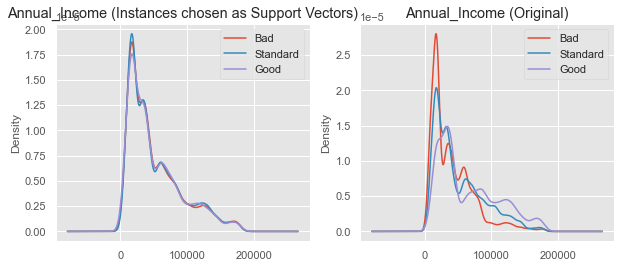

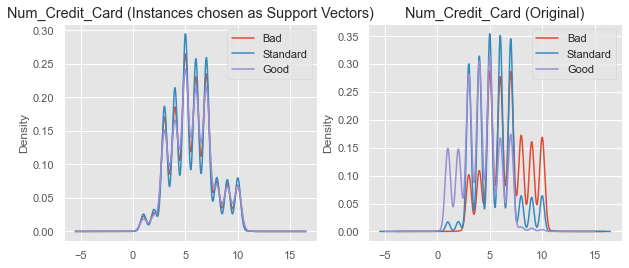

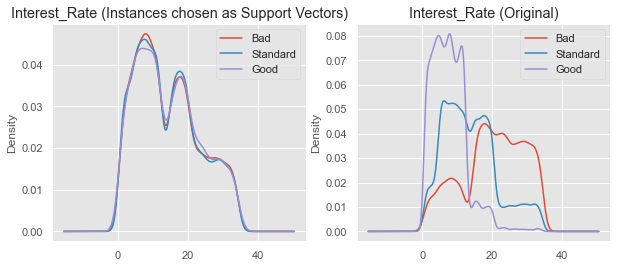

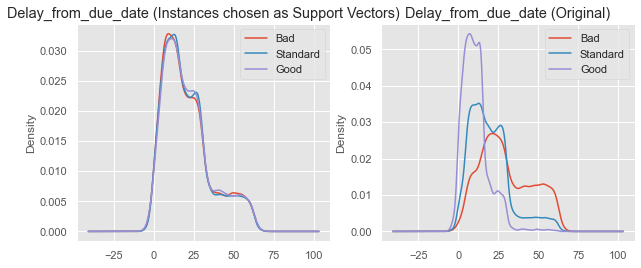

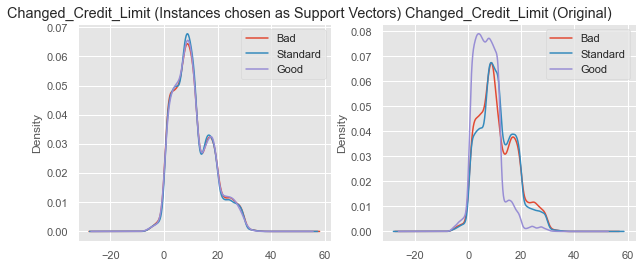

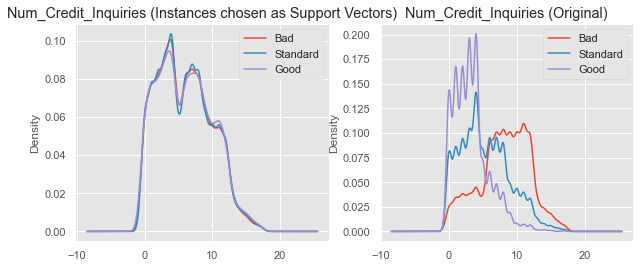

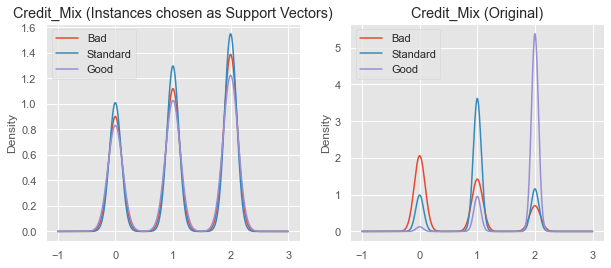

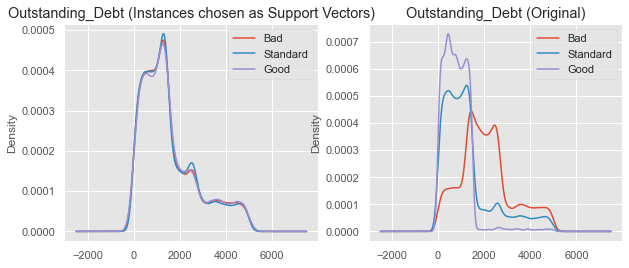

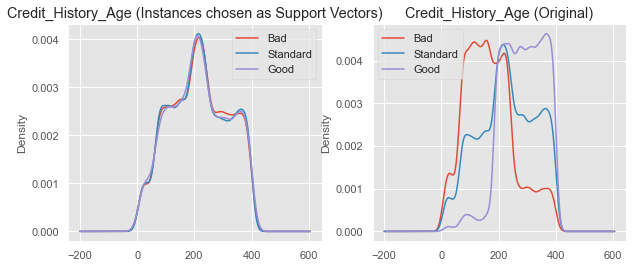

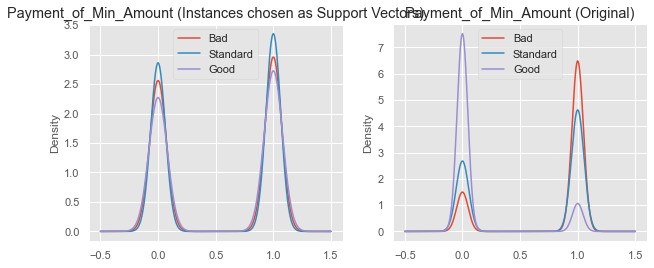

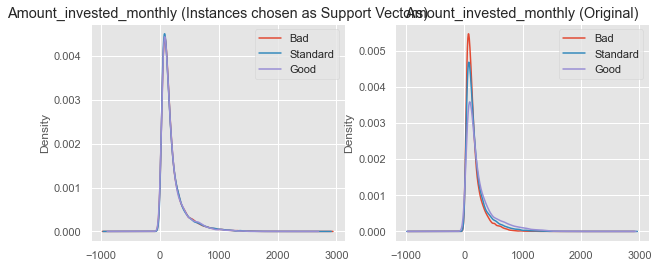

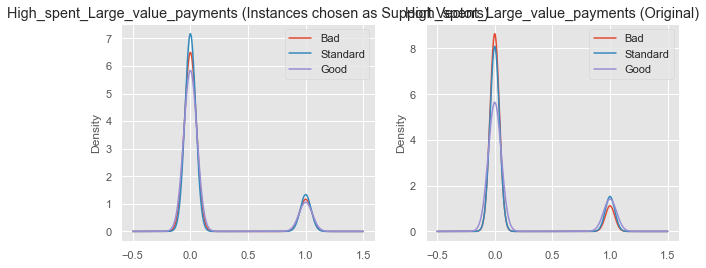

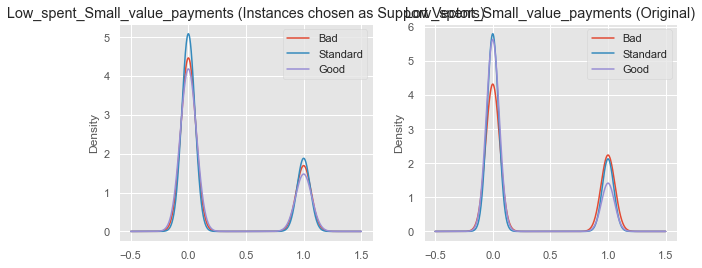

In [176]:
# now lets see the statistics of these attributes
from pandas.plotting import boxplot

# group the original data and the support vectors
df_grouped_support = df_support.groupby(['Credit_Score'])
df_grouped = df_imputed.groupby(['Credit_Score'])

# plot KDE of Different variables
vars_to_plot = ['Annual_Income','Num_Credit_Card','Interest_Rate', 'Delay_from_due_date', 'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt', 'Credit_History_Age', 'Payment_of_Min_Amount', 'Amount_invested_monthly', 'High_spent_Large_value_payments', 'Low_spent_Small_value_payments']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['Bad','Standard', 'Good'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['Bad','Standard', 'Good'])
    plt.title(v+' (Original)')



The above graphs compare the instances chosen as support vectors (graphs on the left) against the distribution of the original data (graphs on the right side). 
There is clearly a difference between those graphs. We can notice that the graphs that reflect the instances chosen as support vectors don't show a clear difference between the three different categories of credit. For some of those graphs on the left is hard to see more than one line on the graph. As opposed to the graphs on the left, that reflect the original data, it's easy to see the separation between the different categories. 

# 2. Model Advantages

The best Logistic Regression model yielded an accuracy score of 0.6555 while the best Support Vector Machine model had 0.7279 score, so for this dataset the best algorithm would be the SVM.  However, though the accuracy of the Logistic Regression was smaller, the algorithm is much faster to run which would allow us to run more tests with the parameters, while the SVM algorithm seems to be much more computationally expensive which limits its tuning process when time is of essence.

Logisitc regression is a helpful tool when evaluating customers' credit scores because it is interpretable. Unlike some 'black box' machine learning algorithms, logistic regression can give insight into how each variable affects a customer's credit score. However, it is important to remember during these interpretations, that correlation does not mean causation and just because a variable is positively correlated with a better credit score does not mean for sure that this variable causes a higher credit score.
